This version contains the 
- updated formulae for the loan calculations, 
- Removed code for low performing f1-score models
- model tuning

**Loan Delinquency Prediction**

Loan default prediction is one of the most critical and crucial problem faced by financial institutions and organizations as it has a noteworthy effect on the profitability of these institutions. In recent years, there is a tremendous increase in the volume of non – performing loans which results in a jeopardizing effect on the growth of these institutions.
 
Therefore, to maintain a healthy portfolio, the banks put stringent monitoring and evaluation measures in place to ensure timely repayment of loans by borrowers. Despite these measures, a major proportion of loans become delinquent. Delinquency occurs when a borrower misses a payment against his/her loan.
 
Given the information like:
- mortgage details, borrowers related details and payment details, 

**Our objective is to identify the delinquency status of loans for the next month given the delinquency status for the previous 12 months (in number of months)**

# Data Dictionary
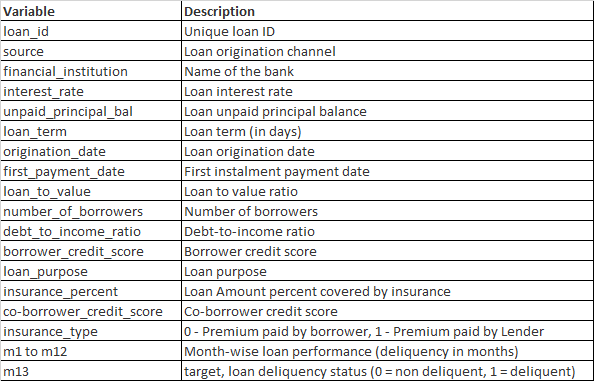

**Equated Monthly Installment**
Calculate EMI and check it is high

$Installment Amount = \frac {P*r*(1 + r)^n}{(1 + r)^n - 1}$

            --
           
**Derieved variables**
If the credit score of borrower and co-borrower is < 700

**Unpaid Principal Balance:** 
The original unpaid principal balance is the amount borrowed, and therefore the amount the borrower owes the lender on the origination date of the loan.

**Loan to Value Ratio:**
The loan-to-value (LTV) ratio is the ratio of a loan to the value of an asset purchased. Ex, if someone borrows 130,000 to purchase a house worth 150000, **the LTV ratio is 130000/150000.** *The higher the LTV ratio, the riskier the loan is for a lender.*

**Debt to Income Ratio**

If you pay 1500 a month for your mortgage and another 100 a month for an auto loan and 400 a month for the rest of your debts, your monthly debt payments are 2000. (1500+100+400=2000) If your gross monthly income is 6000, then your debt-to-income ratio is 33 percent  (2000/6000). *Debt to income ratio > 43% is prone to be delinquent* 


In [495]:
import os
import pandas as pd
import numpy as np
# EDA
import matplotlib.pyplot as plt
import seaborn as sns
# Data Processing
from sklearn.preprocessing import LabelEncoder,imputation,StandardScaler,MinMaxScaler,Binarizer
from sklearn.preprocessing.imputation import Imputer
from category_encoders.one_hot import OneHotEncoder,OrdinalEncoder
import datetime

# Smoting the Dataset to distribute 
from imblearn.over_sampling import SMOTE

# Model building
import keras
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier,RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegressionCV,SGDClassifier,RidgeClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.neural_network import MLPClassifier
# Model Evaluation
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.metrics import classification_report,classification,f1_score,confusion_matrix

%matplotlib inline

In [496]:
pd.set_option('display.max_columns',50)
pd.options.display.float_format = '{:20.3f}'.format

In [497]:
# loading the dataset
na_values = ['',' ','[]','-','?']

def read_data(file_name,na_values):
    path = os.path.join(os.getcwd(),file_name)
    return pd.read_csv(path,
                       parse_dates=['origination_date','first_payment_date'],
                       infer_datetime_format = True,
                       na_values=na_values,
                       encoding='utf-8')

In [498]:
# train_data
file_name = 'train.csv'
df = read_data(file_name=file_name,na_values=na_values)

# Test Data
file_name = 'test.csv'
test = read_data(file_name=file_name,na_values=na_values)

# Data Cleaning

In [499]:
df.shape

(116058, 29)

In [500]:
df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,2012-05-01,95,1.000,22.000,694.000,C86,30.000,0.000,0.000,0,0,0,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,2012-03-01,72,1.000,44.000,697.000,B12,0.000,0.000,0.000,0,0,0,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,2012-03-01,49,1.000,33.000,780.000,B12,0.000,0.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,2012-04-01,46,2.000,44.000,633.000,B12,0.000,638.000,0.000,0,0,0,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,2012-04-01,80,1.000,43.000,681.000,C86,0.000,0.000,0.000,0,1,2,3,4,5,6,7,8,9,10,11,1


In [501]:
test.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,Y,Browning-Hart,3.875,417000,360,2012-01-02,Apr-12,75,1,20,790,A23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,X,OTHER,4.500,113000,360,2012-01-02,Apr-12,80,2,33,793,C86,0,784,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Y,OTHER,4.500,72000,360,2012-01-01,Mar-12,75,1,34,710,C86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,2012-01-02,Apr-12,41,2,24,798,A23,0,813,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,X,Browning-Hart,3.250,166000,180,2012-01-02,Apr-12,53,2,12,767,A23,0,768,0,0,0,0,0,0,0,0,0,0,0,0,0


In [502]:
# Compute amoritization period
test.first_payment_date = pd.to_datetime(test.first_payment_date,format='%b-%y')
test.origination_date   = pd.to_datetime(test.origination_date.apply(lambda x: x.strftime(format='%Y-%d-%m')))

In [503]:
test.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,Y,Browning-Hart,3.875,417000,360,2012-02-01,2012-04-01,75,1,20,790,A23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,X,OTHER,4.500,113000,360,2012-02-01,2012-04-01,80,2,33,793,C86,0,784,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Y,OTHER,4.500,72000,360,2012-01-01,2012-03-01,75,1,34,710,C86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,2012-02-01,2012-04-01,41,2,24,798,A23,0,813,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,X,Browning-Hart,3.250,166000,180,2012-02-01,2012-04-01,53,2,12,767,A23,0,768,0,0,0,0,0,0,0,0,0,0,0,0,0


In [504]:
df['amort_days'] = (df.first_payment_date - df.origination_date).dt.days
test['amort_days'] = (test.first_payment_date - test.origination_date).dt.days 

### Creating a set of derived variables

**Equated Monthly Installment**
Calculate EMI and check it is high

$Installment Amount = \frac {P*r*(1 + r)^n}{(1 + r)^n - 1}$
           
**Derieved variables**
If the credit score of borrower and co-borrower is < 700

**Unpaid Principal Balance:** 
The original unpaid principal balance is the amount borrowed, and therefore the amount the borrower owes the lender on the origination date of the loan.

**Loan to Value Ratio:**
The loan-to-value (LTV) ratio is the ratio of a loan to the value of an asset purchased. Ex, if someone borrows 130,000 to purchase a house worth 150000, **the LTV ratio is 130000/150000.** *The higher the LTV ratio, the riskier the loan is for a lender.*

**Debt to Income Ratio**

If you pay 1500 a month for your mortgage and another 100 a month for an auto loan and 400 a month for the rest of your debts, your monthly debt payments are 2000. (1500+100+400=2000) If your gross monthly income is 6000, then your debt-to-income ratio is 33 percent  (2000/6000). *Debt to income ratio > 43% is prone to be delinquent* 


In [505]:
# Convert the dataframe to lower case
lower_case = lambda x: x.str.lower() if x.dtype == 'object' else x

# Apply it to the dataframe
df = df.apply(lower_case)
test = test.apply(lower_case)

In [506]:
# saving the date times for furture evaluations
tr_orig_dt,tr_frst_pyment_dt = df['origination_date'],df['first_payment_date']
tst_orig_dt,tst_frst_pyment_dt = test['origination_date'],df['first_payment_date']

# Converting first payment and origination dates to str Objects
df['origination_date'],df['first_payment_date'] = df.origination_date.astype('str'),df.first_payment_date.astype('str')
test['origination_date'],test['first_payment_date'] = test.origination_date.astype('str'), test.first_payment_date.astype('str')

In [508]:
# Calculate the EMI of loanees
def emi(p,r,n):
    rate = r/1200        # rate of interest per annum converted to per month
    n_months = n/12             # rate of interest in days converted to per month
    power = pow((1+rate),n_months)
    emi = (p*rate*power)/(power-1)
    return emi

In [509]:
# computing the emi of the loan of the loanees
df['emi'] = df.apply(lambda x: emi(x.unpaid_principal_bal,x.interest_rate,x.loan_term),axis=1)  #(1+df.interest_rate/1200)(df.loan_term/12)) #/((1+df.interest_rate/1200)^(df.loan_term/12)-1)
test['emi'] = test.apply(lambda d: emi(d.unpaid_principal_bal,d.interest_rate,d.loan_term),axis=1)

In [510]:
# Check credit score of borrower and co-borrower is < 700. 
df['is_borrower_score_lt_600'] = df.borrower_credit_score.apply(lambda x: 1 if x < 700 else 0)
df['is_co_borrower_score_lt_600'] = df['co-borrower_credit_score'].apply(lambda x: 1 if x < 700 else 0)

test['is_borrower_score_lt_600'] = test.borrower_credit_score.apply(lambda x: 1 if x < 700 else 0)
test['is_co_borrower_score_lt_600'] = test['co-borrower_credit_score'].apply(lambda x: 1 if x < 700 else 0)

# If the debt-to-income ratio is > 43 the probability of delinquency is higher
df['is_debt_inc_ratio_gt_43'] = df.debt_to_income_ratio.apply(lambda x: 1 if x > 43 else 0)
test['is_debt_inc_ratio_gt_43'] = test.debt_to_income_ratio.apply(lambda x: 1 if x > 43 else 0)

# If the loan_to_value ratio is > 80 the probability of delinquency is lower, else higher
df['is_loan_to_value_ratio_gt_80'] = df.loan_to_value.apply(lambda x: 1 if x < 80 else 0)
test['is_loan_to_value_ratio_gt_80'] = test.loan_to_value.apply(lambda x: 1 if x < 80 else 0)

In [511]:
# Check if columns in test and train df match
if np.prod(df.drop(columns='m13',axis=1).columns == (test.iloc[:,:].columns)):
    print("All Columns Match between train and test datsets")

All Columns Match between train and test datsets


In [512]:
# Check if the origination dates of test and train dates are identical
if (test.origination_date.unique().sort()) == (df.origination_date.unique().sort()):
    print("Origination date between test and train datasets are identical")

Origination date between test and train datasets are identical


In [513]:
# Check if the categories of 'financial_institution' in the test and train datasets are identical
k = (test.financial_institution.astype('category').cat.categories) == (df.financial_institution.astype('category').cat.categories)
if np.prod(k): print("All categories in financial_institution match.\n") 
else: print('mismatch in categories')

All categories in financial_institution match.



In [514]:
print('NAs in the dataset:')
print('train: ',(df.isna().sum()>0).values.sum())
print('test : ', (test.isna().sum()>0).values.sum())

NAs in the dataset:
train:  0
test :  0


In [515]:
print('Duplicates in train loan_id are:',df.loan_id.duplicated().sum()) 
print('Duplicates in test  loan_id are:',test.loan_id.duplicated().sum()) 

# Dropping the loan_ids
df.drop(columns=['loan_id'],axis=1,inplace=True)
test.drop(columns=['loan_id'],axis=1,inplace=True)

Duplicates in train loan_id are: 0
Duplicates in test  loan_id are: 0


# Exploratory Data Analysis

C:\Users\Vijay\anaconda\Anaconda3\envs\keras\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Vijay\anaconda\Anaconda3\envs\keras\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


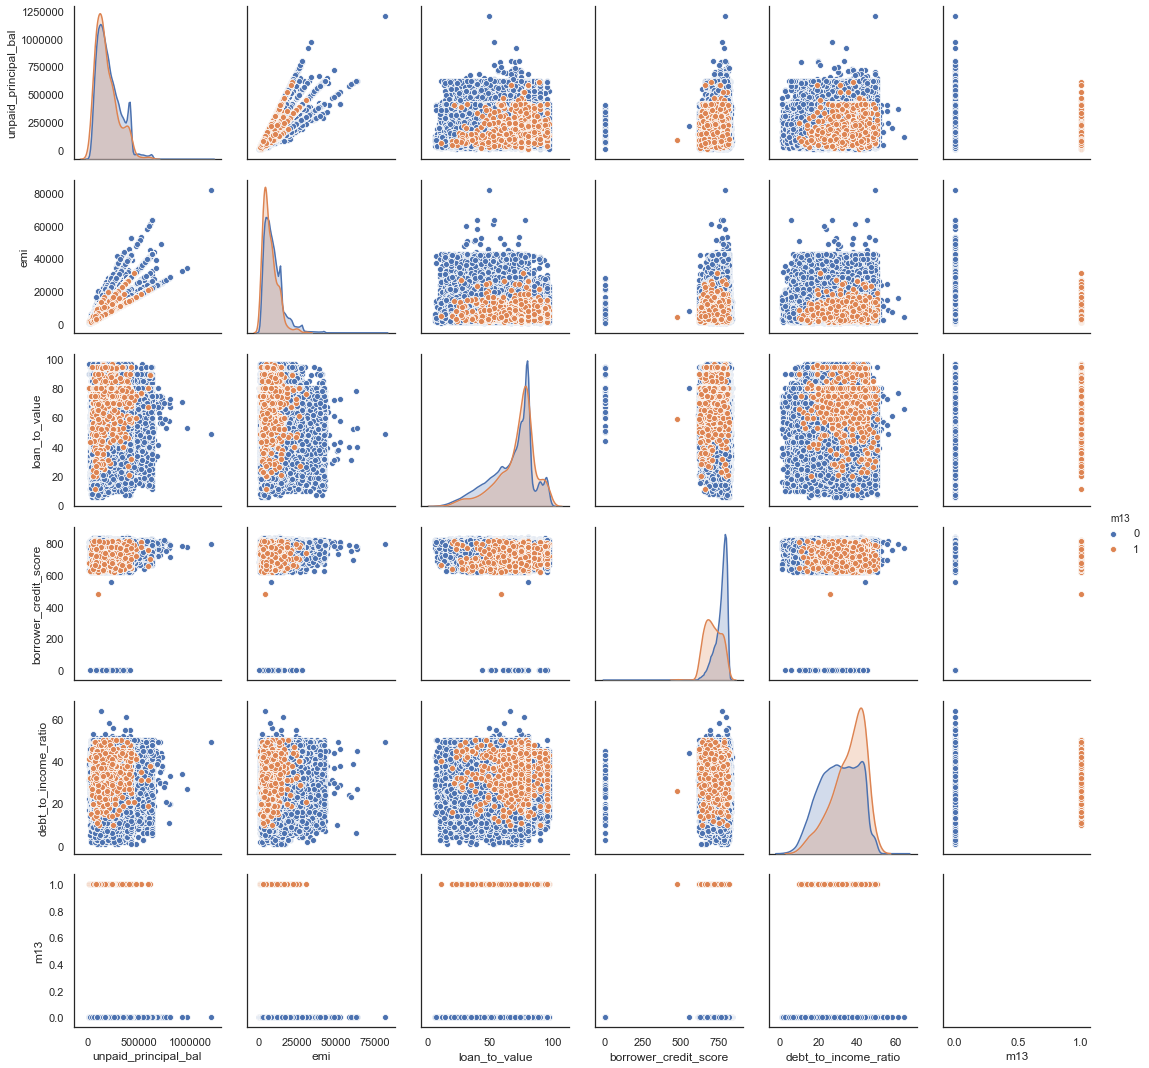

In [516]:
sns.pairplot(data=df[['unpaid_principal_bal','emi','loan_to_value',
                      'borrower_credit_score','debt_to_income_ratio','m13']],
             diag_kind='kde',
             hue='m13')

Apparently, there are outliers in 
- unpaid principal beyond 500K and debt to income ratio upto 50 have most of loans delingquent. There are Outliers in the Unpaid princiap beyond 700K.
- Similarly, most of the emis upto 25K and debt to income ratio of upto 40k have most of loans delinquent. There are outliers in EMI beyond 42K

In [22]:
def count_plt(df,col,hue,title=None,label_rotate=0):
    ax = sns.countplot(x= col,
                       data=df,
                       hue = hue,
                       order = df[col].value_counts().index.to_list())

    total = df.shape[0]  # total number of rows in the dataset
    for p in ax.patches:
        height = p.get_height()
        ax.text(x=p.get_x()+p.get_width()/2.,
                y=height, 
                s= '{:1.2f}%'.format(height/total*100), 
                ha="center" )
    for item in ax.get_xticklabels():
        item.set_rotation(label_rotate)
    plt.title(title)

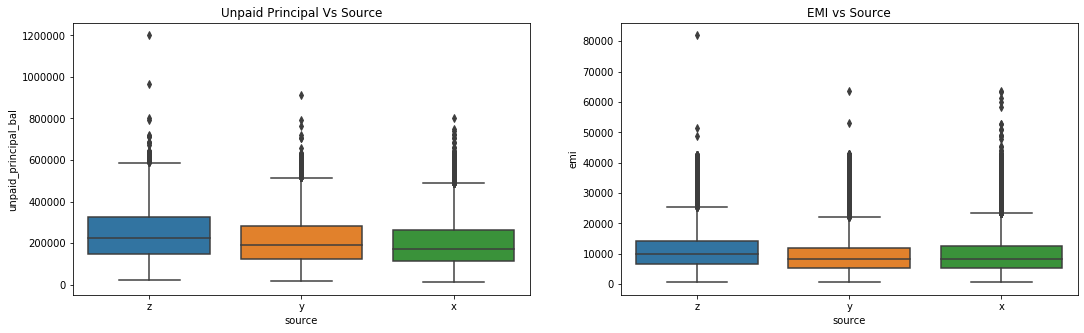

In [23]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
sns.boxplot(x=df.source ,y=df['unpaid_principal_bal'])
plt.title("Unpaid Principal Vs Source")

plt.subplot(1,2,2)
sns.boxplot(x=df.source,y=df.emi)
plt.title("EMI vs Source")
plt.show()

There are significant number of outliers. In addition Unpaid Principal and Emi have dense outliers about the source of Loan. 

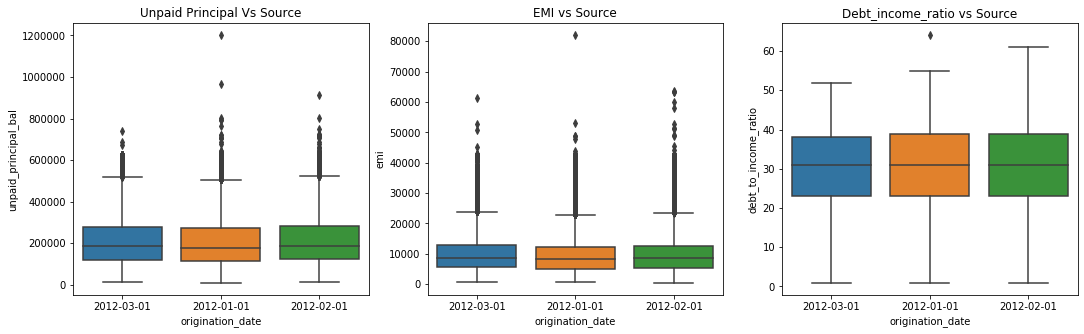

In [24]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.boxplot(x=df.origination_date ,y=df['unpaid_principal_bal'])
plt.title("Unpaid Principal Vs Source")

plt.subplot(1,3,2)
sns.boxplot(x=df.origination_date,y=df.emi)
plt.title("EMI vs Source")

plt.subplot(1,3,3)
sns.boxplot(x=df.origination_date,y=df['debt_to_income_ratio'])
plt.title("Debt_income_ratio vs Source")
plt.show()

In [25]:
(df.emi.quantile(q=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.998]))

0.01                1797.76
0.10                3543.42
0.25                5315.78
0.50                8377.44
0.75               12554.99
0.90               17152.76
0.95               21540.90
1.00               41004.23
Name: emi, dtype: float64

There are outlier beyond 500K and below 2K in Unpaid Principal and EMi 40K

In [26]:
df.debt_to_income_ratio.quantile(q=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.995])

0.01                  10.00
0.10                  17.00
0.25                  23.00
0.50                  31.00
0.75                  39.00
0.90                  43.00
0.95                  45.00
0.99                  49.00
Name: debt_to_income_ratio, dtype: float64

In [33]:
df.unpaid_principal_bal.quantile(q=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.998],)

0.01               43000.00
0.10               81000.00
0.25              120000.00
0.50              183000.00
0.75              278000.00
0.90              384000.00
0.95              417000.00
1.00              626000.00
Name: unpaid_principal_bal, dtype: float64

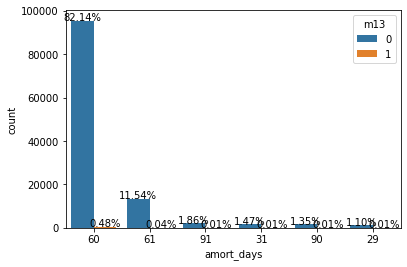

In [28]:
count_plt(df,col='amort_days',hue='m13')

large number of loans are delinquent at 60 days amortization

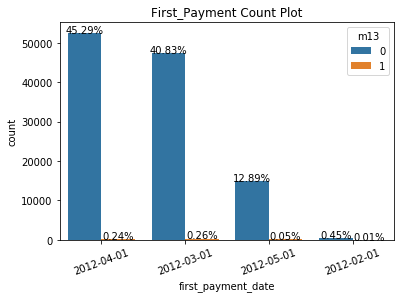

In [29]:
count_plt(df=df,col='first_payment_date',hue='m13',title='First_Payment Count Plot',label_rotate=20)

Loans borrowed in the month of April and March are significantly delinquient

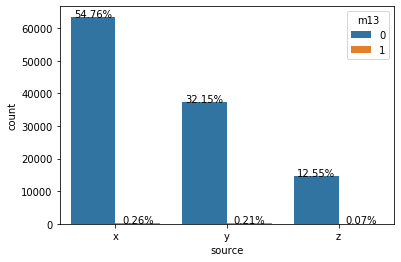

In [30]:
count_plt(df=df,
          col='source',
          hue='m13')
plt.show()

A Large number of loans have originated from X. Most of the loans from this source are delinquent 

In [ ]:
# df_rand = df.sample(n=10000,axis=0,random_state=10)

# g = sns.FacetGrid(data = df_rand,col='first_payment_date',row='origination_date',hue='m13',
#                   legend_out=True,
#                   margin_titles=True,
#                   hue_order= df_rand['m13'].value_counts().index.to_list()
#                  )
# g.map(plt.scatter,'loan_to_value','unpaid_principal_bal',)
# plt.legend()
# plt.show()

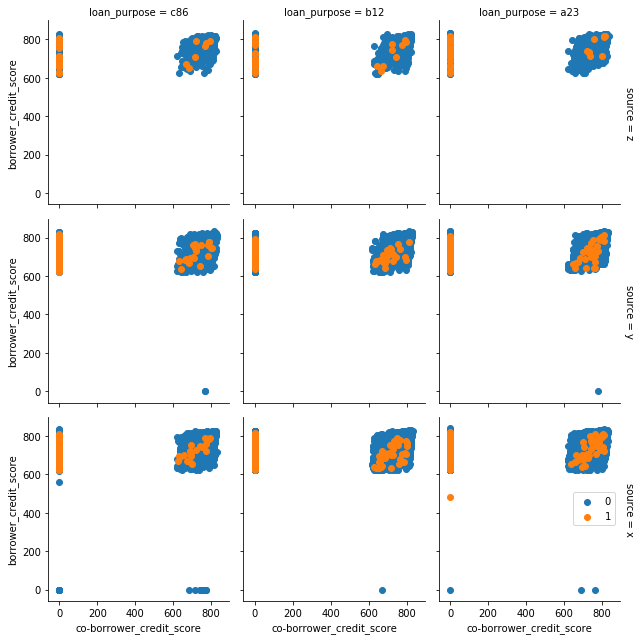

In [31]:
g = sns.FacetGrid(data = df,col='loan_purpose',row='source',hue='m13',
                  legend_out=True,
                  margin_titles=True,
                  hue_order= df['m13'].value_counts().index.to_list()
                 )
g.map(plt.scatter,'co-borrower_credit_score','borrower_credit_score',)
plt.legend()
plt.show()

- There is a direct correlation between borrower credit score and co-borrower credit score. 
- This relation is predominantly linear exhibiting strong correlation between source of funds: x,y and loan purpose c86, b12

Insurance type 0, where insurance paid by the borrower has most number cases of delinquency. It can also be observed that Financial institution other most number of 

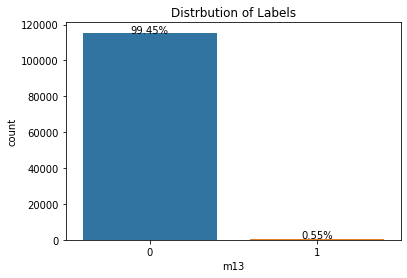

In [32]:
# Find the distribution of Target Variable
count_plt(df=df,col='m13',hue=None,title="Distrbution of Labels")

Just **0.55%** percent of data is delinquent. We have identify the factors that led to the delinquency

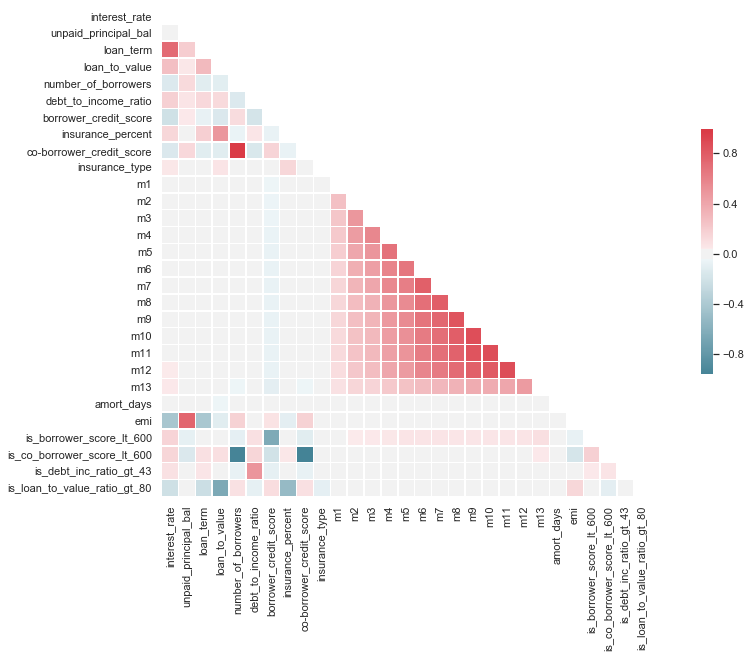

In [41]:
sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = df.copy()

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True # upper triangle to 1 to mask out the colors wi

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=220, h_pos=10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.99, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=False)

 - Months m5-m12 show strong correlation among themselves. These variables do not seam to have any correlation with the other set of continuous variables.
 - debt_to_income_ratio and the co-borrower score show some strong correaltion
 - loan_term and interest_rate percent. 
 - loan_to_value and insurance percent are the variables that show good correaltion among themselves.

Across the sources, and with one co_borrower there is more delinquency in the data

## Outliers Analysis

C:\Users\Vijay\anaconda\Anaconda3\envs\keras\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Vijay\anaconda\Anaconda3\envs\keras\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


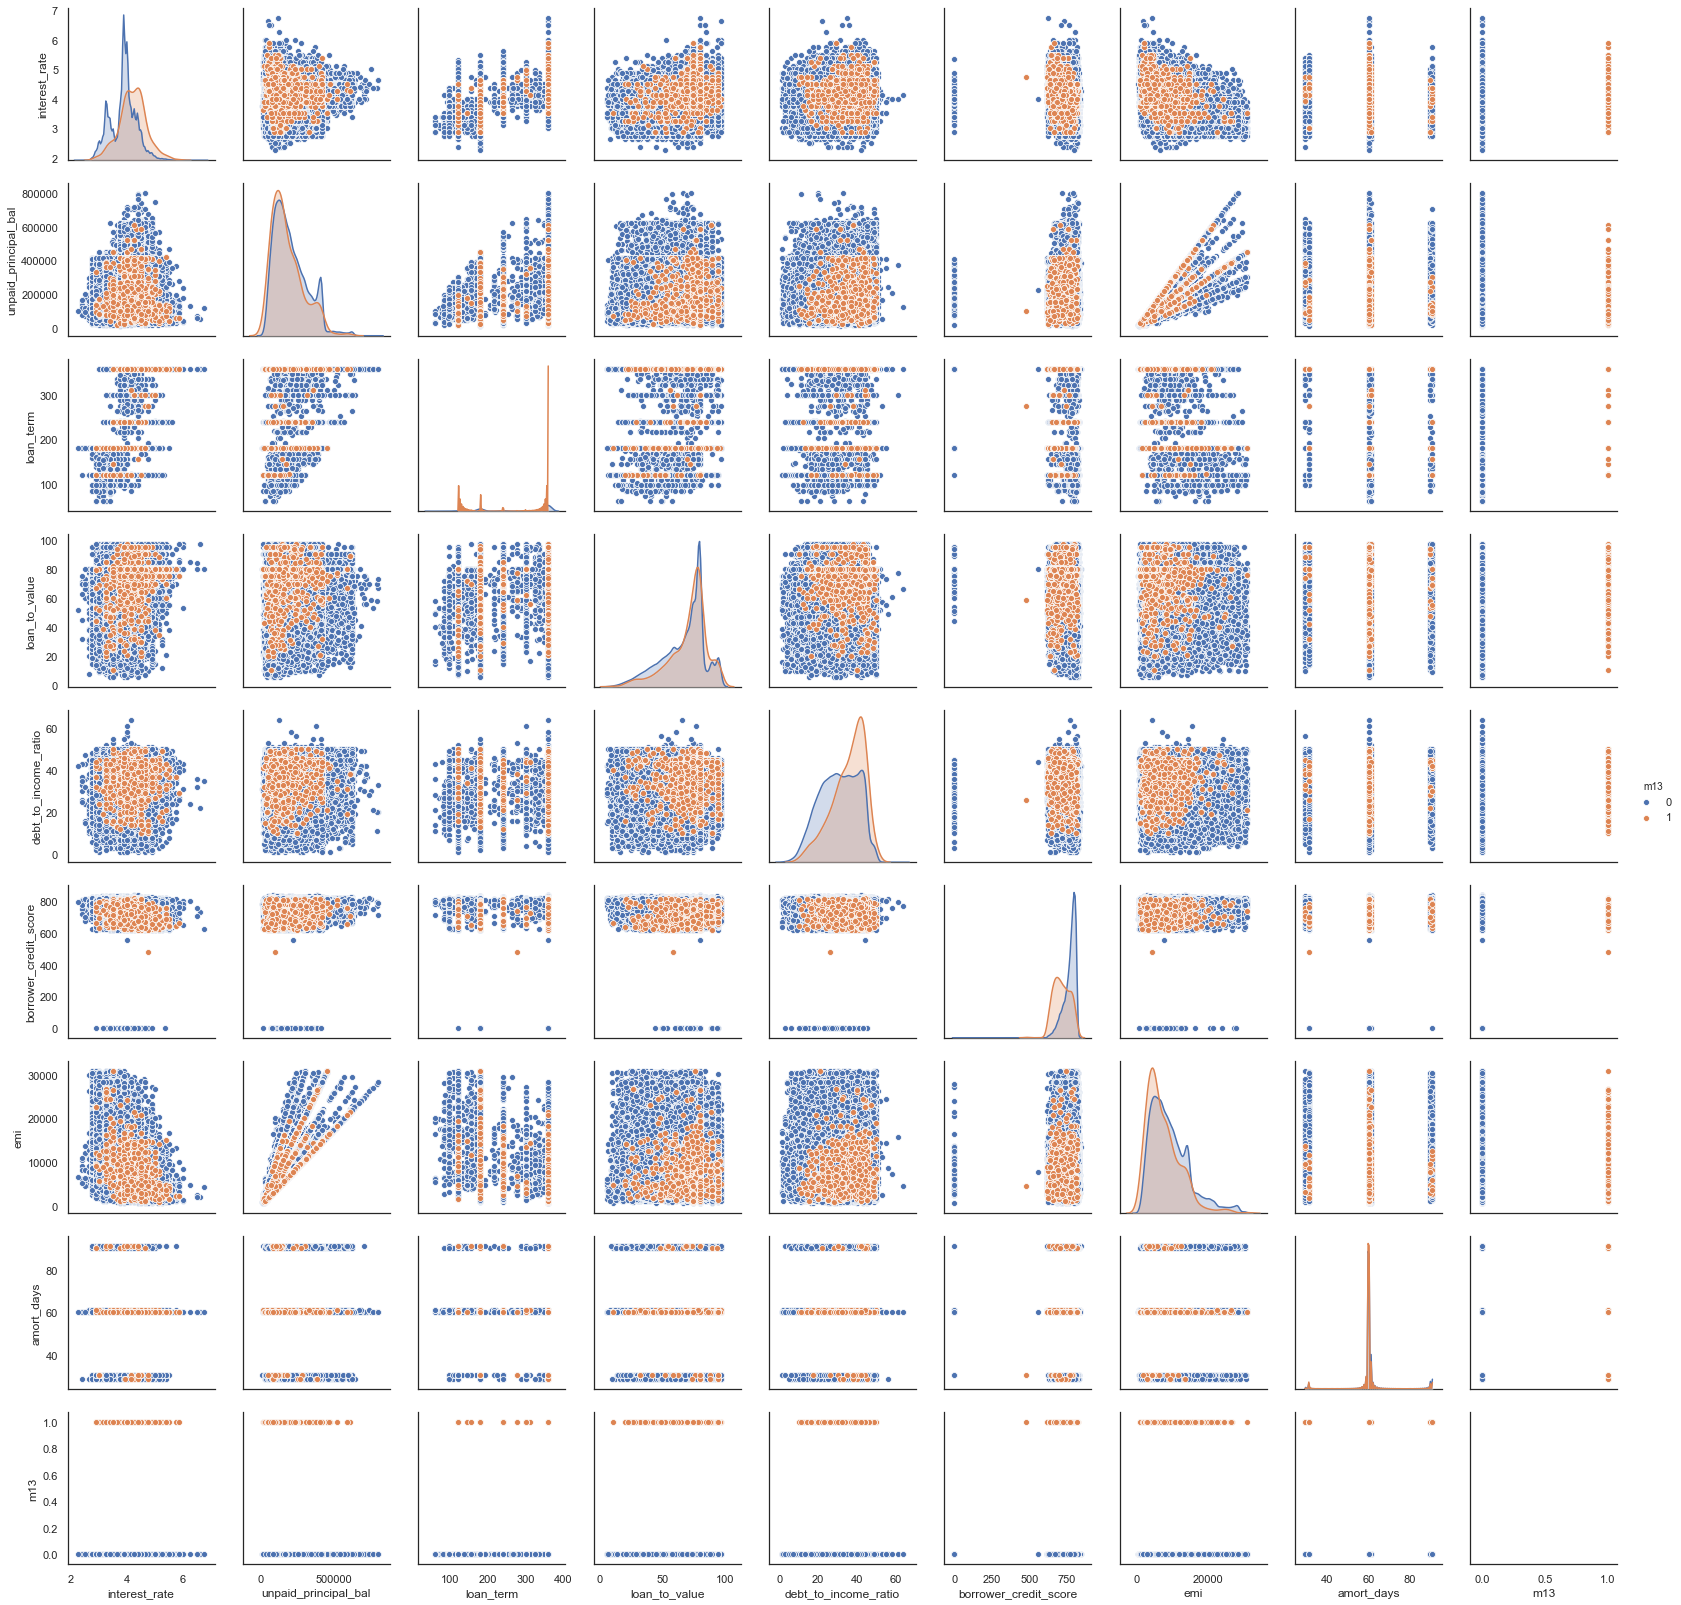

In [93]:
# sns.pairplot(df_non_outliers[cols],hue= 'm13',diag_kind='kde')

# Normalizaing the outliers using log function

In [517]:
df.apply(min)
# normalize outliers found in unpaid_principal_bal, emi, loan_to_value, debt_to_income_ratio to logarithmic values

source                                            x
financial_institution               anderson-taylor
interest_rate                                 2.250
unpaid_principal_bal                          11000
loan_term                                        60
origination_date                         2012-01-01
first_payment_date                       2012-02-01
loan_to_value                                     6
number_of_borrowers                           1.000
debt_to_income_ratio                          1.000
borrower_credit_score                         0.000
loan_purpose                                    a23
insurance_percent                             0.000
co-borrower_credit_score                      0.000
insurance_type                                0.000
m1                                                0
m2                                                0
m3                                                0
m4                                                0
m5          

In [518]:
cols = ['unpaid_principal_bal', 'emi', 'loan_to_value', 'debt_to_income_ratio']

sns.pairplot(pd.concat([df[cols].apply(np.log),df.m13],axis=1),hue='m13',diag_kind='kde')

In [519]:
# df.columns

Index(['source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13', 'amort_days', 'emi', 'is_borrower_score_lt_600',
       'is_co_borrower_score_lt_600', 'is_debt_inc_ratio_gt_43',
       'is_loan_to_value_ratio_gt_80'],
      dtype='object')

In [524]:
# Convert the values to logarithmic form to reduce the effect of outliers
df_new = pd.concat([ df.drop(columns=cols,axis=1), # Drop columns that were identified with outliers
                   df[cols].apply(np.log)],         # convert the outliers to logarithmic form
                   axis=1)

test_new = pd.concat([test.drop(columns = cols,axis=1),
                     test[cols].apply(np.log)],
                    axis=1)

# OneHot, Label and Category Encoding of train and test dataset

In [545]:
def cat_conv(df,col, encoder = 'label'):
    
    '''
    This Function is used to encode category le encoder label, OneHot Encoder, Ordinal Encoder
    encoder : default is label_enconder, for ordinal_encoder, choose 'None'
    '''
    
    df_copy = df.copy()
    # For label Encoder
    if (encoder == 'label') & (col == None): 
        df_copy.financial_institution = df_copy.financial_institution.astype('category')
        cols = df_copy.select_dtypes(include='object').columns.to_list()

        # Instantiate Label Encoder
        enc = OneHotEncoder(cols=cols,drop_invariant=True,use_cat_names=True)

        # Fit and transform
        enc_fit = enc.fit(df_copy.select_dtypes(include='object'))
        X = df_copy[cols]
        df_one_hot_trnsfm = enc_fit.transform(X=X)
        df_one_hot_inv_trnsfm = enc_fit.inverse_transform(X_in=df_one_hot_trnsfm)
        
        return df_one_hot_trnsfm, df_one_hot_inv_trnsfm

    else:
        df_copy.financial_institution = df_copy.financial_institution.astype('object')
        
        # Creating a mapping of categories by order of value counts
        bucket_categories = df_copy[col].value_counts().index.tolist()
        X_map = [(cat,i+1) for i,cat in enumerate((bucket_categories))] # Assign i+1 value to each category
        mapping=[{'col': col, 'mapping': X_map}]

        # Instantiating the Ordinal Encoder
        encoder = OrdinalEncoder(cols=[col],
                                 mapping= mapping,
                                 drop_invariant=True)
        X = df_copy[[col]]
        print(X.dtypes)

        # Fit and Transform the ordinal Encoder
        cat_enc_fit = encoder.fit(X)
        cat_enc_trnsfm = cat_enc_fit.transform(X)
        cat_enc_invtrnsfm = cat_enc_fit.inverse_transform(X_in=cat_enc_trnsfm)
        return cat_enc_trnsfm, cat_enc_invtrnsfm

In [546]:
# Categorical_encoding of train dataset
financial_institution = cat_conv(df=test,col='financial_institution',encoder=None)[0]
print(financial_institution.head(2))

financial_institution    object
dtype: object
   financial_institution
0                      2
1                      1


In [547]:
# # Categorical_encoding of train dataset
financial_institution = cat_conv(df=df_new,col='financial_institution',encoder=None)[0]
print(financial_institution.head(2))

# One_hot encoder
one_hot = cat_conv(df=df_new,col=None,encoder='label')[0]
(one_hot.head(3))

# # Categorical_encoding of test dataset
financial_institution_test = cat_conv(df=test_new,col='financial_institution',encoder=None)[0]
print(financial_institution_test.head(2))

# One_hot encoder
one_hot_test = cat_conv(df=test_new,col=None,encoder='label')[0]
one_hot_test.head(3)

financial_institution    object
dtype: object
   financial_institution
0                      8
1                      3
financial_institution    object
dtype: object
   financial_institution
0                      2
1                      1


,source_y,source_x,source_z,origination_date_2012-02-01,origination_date_2012-01-01,origination_date_2012-03-01,first_payment_date_2012-04-01,first_payment_date_2012-03-01,first_payment_date_2012-05-01,first_payment_date_2012-02-01,loan_purpose_a23,loan_purpose_c86,loan_purpose_b12
0,1,0,0,1,0,0,1,0,0,0,1,0,0
1,0,1,0,1,0,0,1,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,0,0,0,1,0


In [548]:
one_hot.head(3)

,source_z,source_y,source_x,origination_date_2012-03-01,origination_date_2012-01-01,origination_date_2012-02-01,first_payment_date_2012-05-01,first_payment_date_2012-03-01,first_payment_date_2012-04-01,first_payment_date_2012-02-01,loan_purpose_c86,loan_purpose_b12,loan_purpose_a23
0,1,0,0,1,0,0,1,0,0,0,1,0,0
1,0,1,0,0,1,0,0,1,0,0,0,1,0
2,1,0,0,0,1,0,0,1,0,0,0,1,0


In [554]:
one_hot_test.head(3)

,source_y,source_x,source_z,origination_date_2012-02-01,origination_date_2012-01-01,origination_date_2012-03-01,first_payment_date_2012-04-01,first_payment_date_2012-03-01,first_payment_date_2012-05-01,first_payment_date_2012-02-01,loan_purpose_a23,loan_purpose_c86,loan_purpose_b12
0,1,0,0,1,0,0,1,0,0,0,1,0,0
1,0,1,0,1,0,0,1,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,0,0,0,1,0


In [555]:
# concatenating the dataset after converting train and test datasets to numeric
# train numeric dataset
temp_df_train = pd.concat(objs=[one_hot,
                                financial_institution,
                                df_new.select_dtypes(exclude=['object'])],
                          axis=1) #.head()

# test numeric dataset
temp_df_test = pd.concat(objs=[one_hot_test,
                               financial_institution_test,
                               test_new.select_dtypes(exclude=['object'])],
                         axis=1) #.head()



In [557]:
temp_df_test.columns 

Index(['source_y', 'source_x', 'source_z', 'origination_date_2012-02-01',
       'origination_date_2012-01-01', 'origination_date_2012-03-01',
       'first_payment_date_2012-04-01', 'first_payment_date_2012-03-01',
       'first_payment_date_2012-05-01', 'first_payment_date_2012-02-01',
       'loan_purpose_a23', 'loan_purpose_c86', 'loan_purpose_b12',
       'financial_institution', 'interest_rate', 'loan_term',
       'number_of_borrowers', 'borrower_credit_score', 'insurance_percent',
       'co-borrower_credit_score', 'insurance_type', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'amort_days',
       'is_borrower_score_lt_600', 'is_co_borrower_score_lt_600',
       'is_debt_inc_ratio_gt_43', 'is_loan_to_value_ratio_gt_80',
       'unpaid_principal_bal', 'emi', 'loan_to_value', 'debt_to_income_ratio'],
      dtype='object')

In [558]:
temp_df_train.drop(columns='m13',axis=1).columns

Index(['source_z', 'source_y', 'source_x', 'origination_date_2012-03-01',
       'origination_date_2012-01-01', 'origination_date_2012-02-01',
       'first_payment_date_2012-05-01', 'first_payment_date_2012-03-01',
       'first_payment_date_2012-04-01', 'first_payment_date_2012-02-01',
       'loan_purpose_c86', 'loan_purpose_b12', 'loan_purpose_a23',
       'financial_institution', 'interest_rate', 'loan_term',
       'number_of_borrowers', 'borrower_credit_score', 'insurance_percent',
       'co-borrower_credit_score', 'insurance_type', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'amort_days',
       'is_borrower_score_lt_600', 'is_co_borrower_score_lt_600',
       'is_debt_inc_ratio_gt_43', 'is_loan_to_value_ratio_gt_80',
       'unpaid_principal_bal', 'emi', 'loan_to_value', 'debt_to_income_ratio'],
      dtype='object')

In [559]:
# Checing if the columns in train and test dataset have identical columns
if np.sum(temp_df_test.columns == temp_df_train.drop(columns='m13',axis=1).columns):
    print("Train and test datasets have identical columns")
else:
    print("Lengths don't Match")

Train and test datasets have identical columns


# Scaling the dataset X 

In [560]:
# instantiating the standard scaler 
sclr = StandardScaler()

# fit, transform and inverse transform
def sclr_fn(df):
    X = df.copy()
    sclr_fit = sclr.fit(X)
    sclr_trnsfm = sclr_fit.transform(X)
    sclr_inv_trnsfm = sclr_fit.inverse_transform(X)
    return sclr_trnsfm,sclr_inv_trnsfm

In [561]:
# Train
X_train_temp = temp_df_train.drop(columns='m13',axis=1)
y = temp_df_train['m13']

sclr_tnsfm = sclr_fn(df=X_train_temp)[0]
sclr_inv_trnsfm = sclr_fn(df = X_train_temp)[1]

# test
X_test_temp = temp_df_test.copy() 

sclr_tnsfm_test = sclr_fn(df=X_test_temp)[0]
sclr_inv_trnsfm_test = sclr_fn(df = X_test_temp)[1]


# PCA to minimize the number of components

In [674]:
from sklearn.decomposition import PCA

# Instantiating the PCA
pca = PCA(n_components=0.99) # Selecting the components that explain 98% of variance.

# Fitting PCA
pca_fit = pca.fit(X=sclr_tnsfm)

Text(0.5, 1.0, 'Cumulative variance explained by')

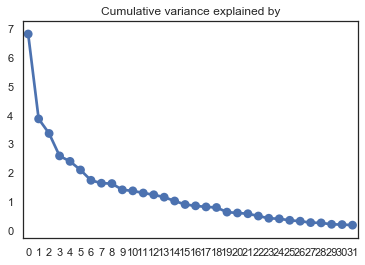

In [675]:
# Fitting the variance
sns.pointplot(list(range(len(pca_fit.explained_variance_))),pca_fit.explained_variance_,markers='o')
plt.title("Cumulative variance explained by")
# considering the the first 25 components that explain most of the variance

In [676]:
# Transforming the scaled data. First 25 components explain 99% of variances in the dataset
pca_trnsfm = pca_fit.transform(X=sclr_tnsfm)
pca_trnsfm_test = pca_fit.transform(X=sclr_tnsfm_test)

# Smoting the dataset to balance target label

In [677]:
# Instantiate SMOTE
smote_smpler = SMOTE(random_state=10,n_jobs=4)

# sclr transm Dataframe
# X = pd.DataFrame(sclr_tnsfm,columns=X_train_temp.columns)
X = pd.DataFrame(data=pca_trnsfm)
y = temp_df_train['m13']

# fit and transform the dataset
smote_fit = smote_smpler.fit_sample(X=X,y=y)

In [678]:
# # Dataframe of smoted dataset
# X = pd.DataFrame(smote_fit[0],columns=X_train_temp.columns)
# y = pd.Series(data=smote_fit[1],name='m13')

# print(X.shape)
# print(y.value_counts())

In [679]:
# Dataframe of smoted dataset
X = pd.DataFrame(smote_fit[0])
y = pd.Series(data=smote_fit[1],name='m13')

print(X.shape)
print(y.value_counts())

(230844, 32)
1    115422
0    115422
Name: m13, dtype: int64


# Splitting the Dataset into train and validation

In [681]:
# Slitting the dataset in to Train and Validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.333, random_state = 10,stratify=y)
print('X_train: ',X_train.shape,'\nX_valid: ',X_valid.shape,'\ny_train: ',y_train.shape,'\ny_valid: ',y_valid.shape)

X_train:  (153972, 32) 
X_valid:  (76872, 32) 
y_train:  (153972,) 
y_valid:  (76872,)


# Model Building

In [682]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier,RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegressionCV,SGDClassifier,RidgeClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.neural_network import MLPClassifier

## Adaboost

In [683]:
# AdaBoost Model instantiation
adaboost_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                                    random_state=10,
                                    n_estimators=100)

# Fitting the Adaboost model on the training dataset
adaboost_model_fit = adaboost_model.fit(X_train,y_train)

# predicting that dataset
adaboost_predict_proba = adaboost_model_fit.predict_proba(X_valid)
y_pred = adaboost_model_fit.predict(X_valid)

print(classification_report(y_true=y_valid,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     38436
           1       0.93      0.91      0.92     38436

    accuracy                           0.92     76872
   macro avg       0.92      0.92      0.92     76872
weighted avg       0.92      0.92      0.92     76872



In [684]:
# F1- Score of the dataset
f1_score(y_true=y_valid,y_pred=y_pred)

0.9212396109173856

In [685]:
conf_matrix = confusion_matrix(y_true=y_valid,y_pred=y_pred)
print("Confusion Matrix for Adaboost Data")
pd.DataFrame(conf_matrix,)

Confusion Matrix for Adaboost Data


,0,1
0,35727,2709
1,3299,35137


In [686]:
tn, fp, fn, tp = conf_matrix.ravel()
print(tn, fp, fn, tp)

35727 2709 3299 35137


In [687]:
# # ada_feat_imp = pd.DataFrame([X.columns,adaboost_model.feature_importances_],index=['feature_name','feature_imp']).T
# # ada_feat_imp = ada_feat_imp.sort_values(by='feature_imp',ascending=False)

# plt.figure(figsize=(6,4))
# sns.barplot(y='feature_name',x='feature_imp',data= ada_feat_imp[ada_feat_imp.feature_imp>0.012])
# plt.show()

## XGBoost

In [688]:
# Instantiating xgboost classifier
# Xgboost parameters
import xgboost as xgb
xgb_params = {'learning_rate': 0.1, 
              'max_depth': 5,
              'subsample': 0.9,        
              'colsample_bytree': 0.9,
              'objective': 'binary:logistic',
              'silent': 1, 
              'n_estimators':500, 
              'gamma':1,
              'min_child_weight':3} 

xgb_clf = xgb.XGBClassifier(**xgb_params, seed = 10)

# Model Fit with training dataset
xgb_clf_fit = xgb_clf.fit(X_train,y_train)

In [689]:
# Model prediction and evaluation with validation dataset
y_pred = xgb_clf_fit.predict(X_valid)

# Printing the classification report and F1-score of the dataset
print(classification_report(y_true=y_valid,y_pred=y_pred,target_names=['non_delinq','delinq']))

              precision    recall  f1-score   support

  non_delinq       1.00      0.98      0.99     38436
      delinq       0.98      1.00      0.99     38436

    accuracy                           0.99     76872
   macro avg       0.99      0.99      0.99     76872
weighted avg       0.99      0.99      0.99     76872



In [690]:
# Printing the classification report and F1-score of the dataset
print(f1_score(y_true=y_valid,y_pred=y_pred))

0.9902155673163805


In [691]:
print(confusion_matrix(y_true=y_valid,y_pred=y_pred))

[[37758   678]
 [   80 38356]]


In [692]:
# Model prediction probabilities with Validation Dataset
xgb_predict_prob = xgb_clf_fit.predict_proba(X_valid)

## RandomForest

In [721]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=800,
#                                 njobs= 1, 
                                random_state=50,max_depth=5)

# Model Fit with training dataset
rf_clf_fit = rf_clf.fit(X_train,y_train)

In [723]:
# Model prediction and evaluation with validation dataset
y_pred = rf_clf_fit.predict(X_valid)

# Printing the classification report and F1-score of the dataset
print(classification_report(y_true=y_valid,y_pred=y_pred,target_names=['non_delinq','delinq']))

              precision    recall  f1-score   support

  non_delinq       0.76      0.96      0.85     38436
      delinq       0.94      0.70      0.81     38436

    accuracy                           0.83     76872
   macro avg       0.85      0.83      0.83     76872
weighted avg       0.85      0.83      0.83     76872



In [724]:
# Printing the classification report and F1-score of the dataset
print(f1_score(y_true=y_valid,y_pred=y_pred))

0.8072161723300608


In [725]:
print(confusion_matrix(y_true=y_valid,y_pred=y_pred))

[[36838  1598]
 [11343 27093]]


In [734]:
# Model prediction probabilities with Validation Dataset
rf_predict_prob = rf_clf_fit.predict_proba(X_valid)

## Neural Network Multi Layer Perceptron Classifier

In [694]:
# Instantiating the MLP Classifier
mlp_clf = MLPClassifier(verbose=1,max_iter= 300,hidden_layer_sizes=(X_train.shape[1],),activation='logistic',
                       solver='adam',alpha=0.00000001,learning_rate='adaptive')

# Fit the traing and test dataset into MLP classifier
mlp_clf.fit = mlp_clf.fit(X=np.asarray(X_train),y=np.asarray(y_train))

Iteration 1, loss = 0.41849699
Iteration 2, loss = 0.36189356
Iteration 3, loss = 0.35663446
Iteration 4, loss = 0.35022021
Iteration 5, loss = 0.34156697
Iteration 6, loss = 0.32993732
Iteration 7, loss = 0.31592278
Iteration 8, loss = 0.30035630
Iteration 9, loss = 0.28440901
Iteration 10, loss = 0.26905781
Iteration 11, loss = 0.25501308
Iteration 12, loss = 0.24246960
Iteration 13, loss = 0.23121157
Iteration 14, loss = 0.22124183
Iteration 15, loss = 0.21202583
Iteration 16, loss = 0.20383944
Iteration 17, loss = 0.19630839
Iteration 18, loss = 0.18944576
Iteration 19, loss = 0.18284884
Iteration 20, loss = 0.17663537
Iteration 21, loss = 0.17093012
Iteration 22, loss = 0.16563584
Iteration 23, loss = 0.16071637
Iteration 24, loss = 0.15640468
Iteration 25, loss = 0.15221019
Iteration 26, loss = 0.14844581
Iteration 27, loss = 0.14502542
Iteration 28, loss = 0.14184766
Iteration 29, loss = 0.13890690
Iteration 30, loss = 0.13612435
Iteration 31, loss = 0.13348980
Iteration 32, los

In [695]:
# Predicting the target variable from the MLP layers
y_pred = mlp_clf.fit.predict(np.asarray(X_valid))

# Computing the F1-score
f1_score(y_valid,y_pred)

0.9736431308296672

In [696]:
mlp_predict_prob = mlp_clf.fit.predict_proba(X_valid)

# Stacking of algorithms

In [735]:
# Predict On Test Data one each of the ensemble of stacked algorithms
test_trnsfm = pd.DataFrame(pca_trnsfm_test) #,columns=temp_df_test.columns)

mlp_test_pred = mlp_clf.fit.predict(test_trnsfm)
# ada_test_pred = adaboost_model_fit.predict(test_trnsfm)
xgb_test_pred = xgb_clf_fit.predict(test_trnsfm)

# Using RandomForest predicting the XGB
rf_test_pred = rf_clf_fit.predict(test_trnsfm)

In [736]:
def to_array(input_array):
    return [j for i,j in np.asarray(input_array)]

In [753]:
xgb = to_array(xgb_predict_prob)
mlp = to_array(mlp_predict_prob)
ada = to_array(adaboost_predict_proba)
# rf  = to_array(rf_predict_prob)

In [754]:
stacked_x_probs = np.column_stack((xgb,
                                   mlp,
                                   ada 
                                   #,rf
                                  )) # Without ADA
stacked_x_probs

array([[4.60544303e-02, 2.49564759e-01, 4.97397797e-01],
       [3.02048423e-03, 6.46143006e-04, 4.77765132e-01],
       [8.76388073e-01, 6.29118864e-01, 5.01355484e-01],
       ...,
       [9.99654174e-01, 9.99998389e-01, 5.16812534e-01],
       [9.99927998e-01, 9.99999999e-01, 5.32510262e-01],
       [9.99973655e-01, 1.00000000e+00, 5.62994455e-01]])

In [755]:
print(pd.Series(ada_test_pred).value_counts())
print(pd.Series(mlp_test_pred).value_counts())
print(pd.Series(xgb_test_pred).value_counts())
# print(pd.Series(rf_test_pred) .value_counts())

0    31567
1     4299
dtype: int64
0    33991
1     1875
dtype: int64
0    34457
1     1409
dtype: int64


In [756]:
stacked_y_preds = np.column_stack((xgb_test_pred,
                                   mlp_test_pred,
                                   ada_test_pred,
#                                    rf_test_pred
                                  ))
print(stacked_y_preds[:5])
print(stacked_y_preds.shape)

[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 1]
 [0 0 0]]
(35866, 3)


# Meta model to predict the probabilities

In [766]:
# meta_model = MLPClassifier()
meta_model = RandomForestClassifier(n_estimators=500,
                                    max_features="log2"
                                   )

# Fitting the meta model
meta_model_fit = meta_model.fit(X=stacked_x_probs, # inputting the stacked probabilities
                                y=y_valid)          # y validate                               ) 

In [767]:
# Predicting the 
meta_predict = meta_model_fit.predict(stacked_y_preds)

# Met
meta_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [768]:
pd.Series(meta_predict).value_counts()

0    35588
1      278
dtype: int64

# Submission Data

In [769]:
# Reading the test data
# test = read_data(file_name=file_name,na_values=na_values)

# Dump the submission Data PDF
submission_data = pd.DataFrame(data=[X_test_temp.index+1,meta_predict],index=['loan_id','m13']).T

# Write to csv
submission_data.to_csv('submission_6.csv',index=False)

In [716]:
# Reading the test data
# test = read_data(file_name=file_name,na_values=na_values)

# Dump the submission Data PDF
submission_data = pd.DataFrame(data=[X_test_temp.index+1,meta_predict],index=['loan_id','m13']).T

# Write to csv
submission_data.to_csv('submission_4.csv',index=False)

In [ ]:
submission_data = pd.DataFrame(data=[X_test_temp.index+1,xgb_test_pred],index=['loan_id','m13']).T

submission_data.to_csv('submission_xgb.csv',index=False)

submission_data = pd.DataFrame(data=[X_test_temp.index+1,mlp_test_pred],index=['loan_id','m13']).T

submission_data.to_csv('submission_mlp.csv',index=False)

submission_data = pd.DataFrame(data=[X_test_temp.index+1,ada_test_pred],index=['loan_id','m13']).T

submission_data.to_csv('submission_ada.csv',index=False)